# Replicating: Machine Learning Prediction of Recessions

## An Imbalanced Classification Approach

This notebook is based on presentation slides which can be found here: 
- https://fdpinstitute.org/resources/Documents/webinars%20thoughtleadership%20pieces%20etc/Al%20Yazdani%20Webinar%20July%208,%202020.pdf

In [3]:
import pandas as pd 
import numpy as np 
import quandl 
import yfinance as yf
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import matplotlib.pyplot as plt 

import plotly as plotly
import plotly.graph_objs as go
import plotly.express as px

In [4]:
# Set notebook mode to work in offline
plotly.offline.init_notebook_mode(connected=True)

### Let's load in the data

Quick summary where I got the data: 
- Quandl: 
    - Recession 
    - Fed Funds 
    - Indpro 
    - nonfarm payroll 
    - unemployment 
- Market Watch: 
    - SPY500 
- Macrotrends: 
    - 10 year Treasury Bond 

In [58]:
# load in merged data 
data = pd.read_csv("../data/replication_data.csv", index_col=0)

In [59]:
data["recession"].head()

Date
1959-01-31    0.0
1959-02-28    NaN
1959-03-31    NaN
1959-04-30    0.0
1959-05-31    NaN
Name: recession, dtype: float64

Looks like the labels can be filled using a forward fill

In [60]:
# fill missing recession data 
data["recession"] = data["recession"].fillna(method='bfill').fillna(method='ffill') 

In [64]:
px.line(data, x= data.index, y='recession')

In [9]:
print("There are a total of {} months of recession in this data".format(data["recession"].sum()))

There are a total of 95.0 months of recession in this data


In [10]:
def log_diff(v): 
    log_diff = np.log(v/v.shift(1))
    return log_diff 

In [11]:
# preprocessing 
data["slope_yc"] = (data["ty10"] - data["fedfunds"])
data["fedfunds"] = data["fedfunds"].diff()
data["indpro"] = log_diff(data["indpro"]) 
data["nonfarm"] =  log_diff(data["nonfarm"])
data["SP500"] =  log_diff(data["SP500"])
data["ty10"]  = (data["ty10"]).diff()
data["unemploy"] = log_diff(data["unemploy"])
data["recession"] = data["recession"].shift(1)

In [12]:
data.head()

,fedfunds,nonfarm,indpro,SP500,ty10,unemploy,recession,slope_yc
Date,,,,,,,,
1959-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1959-02-28,-0.05,0.003994,0.019395,-0.000722,NaN,-0.025646,0.0,NaN
1959-03-31,0.37,0.006168,0.014302,0.000541,NaN,-0.042242,0.0,NaN
1959-04-30,0.16,0.005774,0.021079,0.038048,NaN,-0.062419,0.0,NaN
1959-05-31,-0.06,0.004286,0.014951,0.018750,NaN,-0.026101,0.0,NaN


For the 10 year treasury bond I only found data starting in 1962. 

In [13]:
# drop missing values 
len_before = len(data)
data.dropna(inplace=True)
len_after = len(data)

print("Dropped {} rows".format(len_before - len_after))

Dropped 37 rows


In [14]:
data.head()

,fedfunds,nonfarm,indpro,SP500,ty10,unemploy,recession,slope_yc
Date,,,,,,,,
1962-02-28,0.22,0.005396,0.016226,0.016139,-0.021515,-0.052829,0.0,1.691667
1962-03-31,0.48,0.001575,0.005352,-0.005878,-0.113030,0.012834,0.0,1.098636
1962-04-30,-0.07,0.005898,0.002129,-0.063973,-0.105636,-0.003833,0.0,1.063000
1962-05-31,-0.42,0.000467,-0.001066,-0.089914,0.030636,-0.011070,0.0,1.513636
1962-06-30,0.32,0.000288,-0.002131,-0.085381,0.044935,-0.004931,0.0,1.238571


All looking good! 

### Class Imbalance 

Now let s have a look at the class imbalance discussed in the paper 

In [15]:
c1 = data["recession"].value_counts()[0]
c2 = data["recession"].value_counts()[1]
print(data["recession"].value_counts())
print("The minority class only makes up {} % ".format(round(c2/c1 * 100, 2)))

0.0    610
1.0     85
Name: recession, dtype: int64
The minority class only makes up 13.93 % 


In [16]:
# get x and y 
X = data.drop(['recession'], axis=1)
y = data["recession"]

In [17]:
# divide in train test according to paper 
X_train, y_train =  (X.loc["1962-02-28":"2007-01-01"], y.loc["1962-02-28":"2007-01-01"])
X_test, y_test =  (X.loc["2007-01-01":], y.loc["2007-01-01":])

In [18]:
## Sampling techniques

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# oversample using SMOTE 
sm = SMOTE(random_state=42)
X_train_smote, y_train_smote = sm.fit_resample(X_train, y_train)

# undersample randomly
rus = RandomUnderSampler(random_state=42)
X_train_rnd, y_train_rnd  = rus.fit_resample(X_train, y_train)

In [19]:
train_test_pairs = {"Normal":(X_train, y_train), 
                    "SMOTE":(X_train_smote, y_train_smote), 
                    "Random Undersampling":(X_train_rnd, y_train_rnd)}

In [20]:
clfs = {"Logistic Regression": LogisticRegression(),
       "Decision Tree": tree.DecisionTreeClassifier(),
       "Random Forest": RandomForestClassifier(max_depth=15, 
                                                      n_estimators=200, 
                                                      class_weight = "balanced_subsample", 
                                                      random_state=42)}

### Model Fitting

In [21]:
fig = go.Figure()
fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=0, y1=1
)

for label, pair in train_test_pairs.items(): 
    clf = RandomForestClassifier(max_depth=15, 
                                 n_estimators=200, 
                                 class_weight = "balanced_subsample", 
                                 random_state=42)
    clf.fit(pair[0], pair[1])
    y_pred= clf.predict(X_test) 
    fpr, tpr, thresholds = metrics.roc_curve(y_test, clf.predict_proba(X_test)[:,1])
    auc = metrics.roc_auc_score(y_test, clf.predict(X_test))

    name = f"{label} (AUC={auc:.2f})"
    fig.add_trace(go.Scatter(x=fpr, y=tpr, name=name, mode='lines'))

fig.update_layout(
xaxis_title='False Positive Rate',
yaxis_title='True Positive Rate',
yaxis=dict(scaleanchor="x", scaleratio=1),
xaxis=dict(constrain='domain'),
width=900, height=700
)
fig.update_layout(title_text="Comparing sampling strategies")
fig.show()

In [22]:
fig = go.Figure()
fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=0, y1=1
)

for name, clf in clfs.items(): 
    clf.fit(X_train_rnd, y_train_rnd)
    y_pred= clf.predict(X_test) 
    fpr, tpr, thresholds = metrics.roc_curve(y_test, clf.predict_proba(X_test)[:,1])
    auc = metrics.roc_auc_score(y_test, clf.predict(X_test))

    name = f"{name} (AUC={auc:.2f})"
    fig.add_trace(go.Scatter(x=fpr, y=tpr, name=name, mode='lines'))

fig.update_layout(
    xaxis_title='False Positive Rate',
    yaxis_title='True Positive Rate',
    yaxis=dict(scaleanchor="x", scaleratio=1),
    xaxis=dict(constrain='domain'),
    width=900, height=700
)
fig.update_layout(title_text="Comparing different models")
fig.show()

In [23]:
print(clf)

RandomForestClassifier(class_weight='balanced_subsample', max_depth=15,
                       n_estimators=200, random_state=42)


### Nice, without parameter tuning this already seems about right

In [24]:
y_pred = clf.predict(X_test)
y_pred

array([0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       1., 0., 0.])

### Now what can we do with these predictions?

## Trading Strategy: Long SPY, GLD/VIX during Recession 

In [25]:
import yfinance as yf

results = pd.DataFrame()

results["SPY"] = yf.Ticker("^GSPC").history(period='1d', start='2007-1-1', end= "2019-12-31").Close.resample("M").mean()
results["GLD"] = yf.Ticker("GLD").history(period='1d', start='2007-1-1', end= "2019-12-31").Close.resample("M").mean()
results["VIX"] = yf.Ticker("^VIX").history(period='1d', start='2007-1-1', end= "2019-12-31").Close.resample("M").mean()

In [26]:
# strategies
pred_shift_back = pd.Series(y_pred).shift(-1).fillna(method='ffill')
spy_long_preds = (pred_shift_back -1) *(-1) 
results["SPY Long"] = results["SPY"].pct_change()
results["SPY Long wo recessions"] = spy_long_preds.values * results["SPY Long"].values 
results["SPY Long add GLD"] = ((results["GLD"].pct_change().values * pred_shift_back) + results["SPY Long"].values).values
results["SPY Long add VIX"] = ((results["VIX"].pct_change().values * pred_shift_back) + results["SPY Long"].values).values

In [27]:
fig = go.Figure()
fig.add_scatter(x= results.index, y=results['SPY Long'].cumsum(), mode='lines', name="SPY long")
fig.add_scatter(x= results.index, y=results["SPY Long wo recessions"].cumsum(), mode='lines', name="SPY wo recession")
fig.add_scatter(x= results.index, y=results["SPY Long add GLD"].cumsum(), mode='lines', name="SPY + GLD")
fig.add_scatter(x= results.index, y=results["SPY Long add VIX"].cumsum(), mode='lines', name="SPY + VIX")
fig.update_layout(title_text="Different Strategies during Recessions")
fig.show()


### We can clearly see that the SPY + VIX (in times of predicted recessions) portfolio is the most profitable

## What are our predictions for the coming months 

In [28]:
# features 
fed_funds_data = quandl.get("FRED/FEDFUNDS", collapse="monthly", api_key="VUCaDHTMGVn5xMsaqPtS")
indpro_data = quandl.get("FRED/INDPRO", collapse="monthly", api_key="VUCaDHTMGVn5xMsaqPtS")
nonfarm_payroll_data = quandl.get("FRED/PAYEMS", collapse="monthly", api_key="VUCaDHTMGVn5xMsaqPtS")
unemploy_data = quandl.get("FRED/UNEMPLOY", collapse="monthly", api_key="VUCaDHTMGVn5xMsaqPtS")
spy = yf.Ticker("^GSPC").history(period='1d', start='2019-1-1').Close.resample("M").mean()
ty10 = yf.Ticker("^TNX").history(period='1d', start='2019-1-1').Close.resample("M").mean()

In [29]:
# subsetting recent data  
data = pd.DataFrame()
data["fedfunds"] = fed_funds_data.loc["01-01-2020":].Value
data["nonfarm"] = nonfarm_payroll_data.loc["01-01-2020":].Value
data["indpro"] = indpro_data.loc["01-01-2020":].Value
data["SP500"] = spy.loc["01-01-2020":]
data["ty10"] = ty10.loc["01-01-2020":]
data["unemploy"] = unemploy_data.loc["01-01-2020":].Value

# preprocessing 
data["slope_yc"] = (data["ty10"] - data["fedfunds"]).diff()
data["fedfunds"] = data["fedfunds"].diff()
data["indpro"] = log_diff(data["indpro"]).fillna(method="ffill") # no recent data
data["nonfarm"] =  log_diff(data["nonfarm"])
data["SP500"] =  log_diff(data["SP500"])
data["ty10"]  = (data["ty10"]).diff()
data["unemploy"] = log_diff(data["unemploy"])

In [30]:
#get up to date data 
data.dropna(inplace=True)
print(clf.predict(data))

[0. 1. 1. 0. 0. 0. 0.]


In [31]:
print(clf.predict_proba(data))

[[0.82  0.18 ]
 [0.065 0.935]
 [0.09  0.91 ]
 [0.935 0.065]
 [0.93  0.07 ]
 [0.955 0.045]
 [0.945 0.055]]


### We see that the predicted probability for a recession was far bigger 5-6 months ago!

In [32]:
data.dropna(inplace=True)
data["recession_proba"] = clf.predict_proba(data)[:,1]

In [33]:
fig = go.Figure()
fig.add_scatter(x= data.index, y=data["recession_proba"], mode='lines', name="SPY long")
fig.update_layout(title_text="Confidence in Recession according to the model")
fig.show()

# PART 2 - What did our model learn?

In [34]:
from dtreeviz.trees import *
from pdpbox import pdp, get_dataset, info_plots

/home/lukas/anaconda3/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning:

calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.

/home/lukas/anaconda3/lib/python3.7/site-packages/dask/dataframe/utils.py:13: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.

/home/lukas/anaconda3/lib/python3.7/site-packages/distributed/config.py:20: YAMLLoadWarning:

calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.



In [35]:
clf = RandomForestClassifier(max_depth=15, 
                             n_estimators=200, 
                             class_weight = "balanced_subsample", 
                             random_state=42)
clf.fit(X_train_rnd,y_train_rnd)

RandomForestClassifier(class_weight='balanced_subsample', max_depth=15,
                       n_estimators=200, random_state=42)

### Permutation Importance 

In [36]:
# Permutation Importance 
# see https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html
from sklearn.inspection import permutation_importance

result = permutation_importance(clf, X_test, y_test, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()

fig = go.Figure()
for i in range(0, len(X_test.columns)):
    fig.add_trace(go.Box(x = result.importances[sorted_idx][i], name=X_test.columns[sorted_idx][i]))
fig.show()

In [37]:
#ICE Plot
pdp_nonfarm = pdp.pdp_isolate(
    model=clf, dataset=X, model_features=X.columns, feature='nonfarm'
)
pdp_fedfunds = pdp.pdp_isolate(
    model=clf, dataset=X, model_features=X.columns, feature='fedfunds'
)
pdp_indpro = pdp.pdp_isolate(
    model=clf, dataset=X, model_features=X.columns, feature='indpro'
)
pdp_slopeyc = pdp.pdp_isolate(
    model=clf, dataset=X, model_features=X.columns, feature='slope_yc'
)
pdp_sp500 = pdp.pdp_isolate(
    model=clf, dataset=X, model_features=X.columns, feature='SP500'
)
pdp_unemploy = pdp.pdp_isolate(
    model=clf, dataset=X, model_features=X.columns, feature='unemploy'
)
pdp_ty10 = pdp.pdp_isolate(
    model=clf, dataset=X, model_features=X.columns, feature='ty10'
)

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


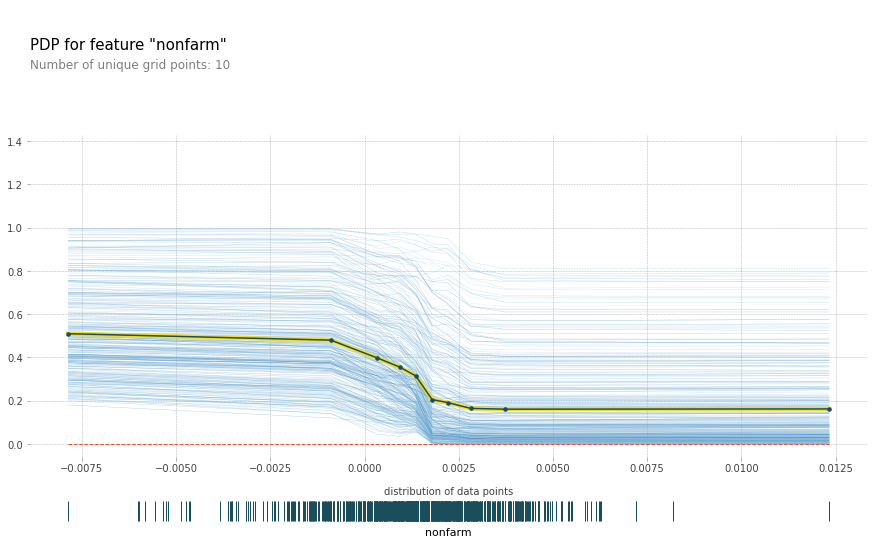

In [38]:
fig, axes = pdp.pdp_plot(pdp_nonfarm, 
                         'nonfarm', 
                         plot_lines=True, 
                         center=False, 
                         frac_to_plot=0.5,
                         plot_pts_dist=True, 
)

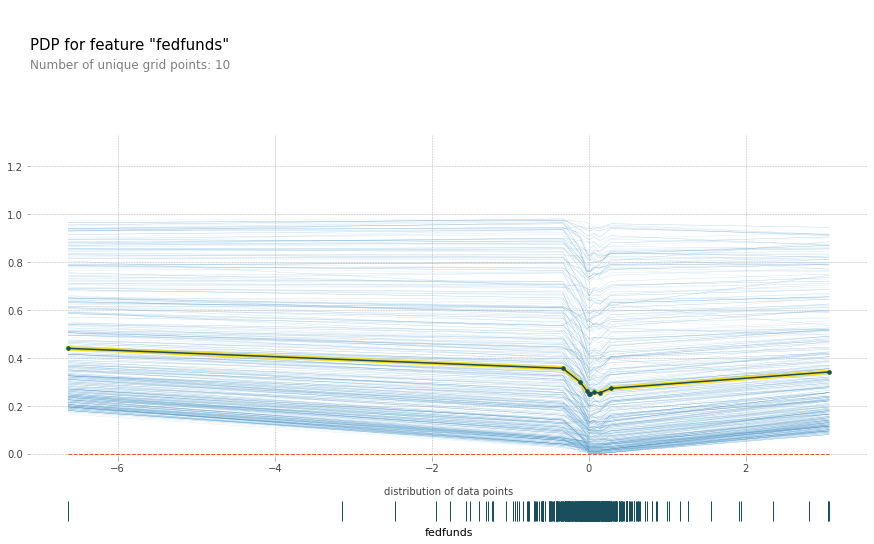

In [39]:
fig, axes = pdp.pdp_plot(pdp_fedfunds, 
                         'fedfunds', 
                         plot_lines=True, 
                         center=False, 
                         frac_to_plot=0.5,
                         plot_pts_dist=True, 
)

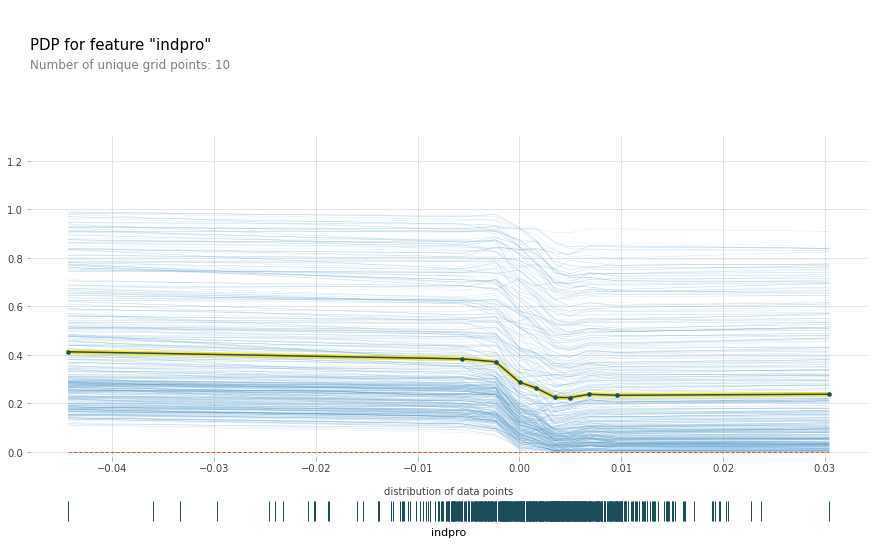

In [40]:
fig, axes = pdp.pdp_plot(pdp_indpro, 
                         'indpro', 
                         plot_lines=True, 
                         center=False, 
                         frac_to_plot=0.5,
                         plot_pts_dist=True, 
)

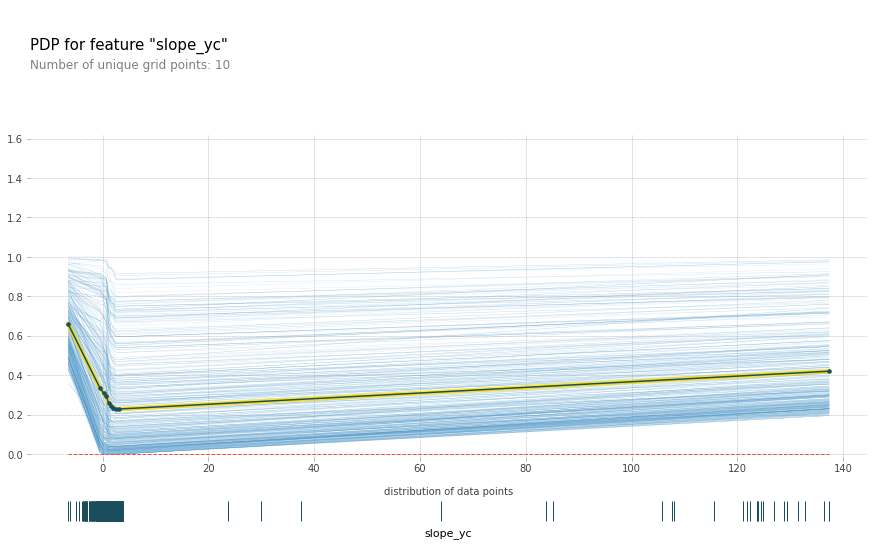

In [41]:
fig, axes = pdp.pdp_plot(pdp_slopeyc, 
                         'slope_yc', 
                         plot_lines=True, 
                         center=False, 
                         frac_to_plot=0.5,
                         plot_pts_dist=True, 
)

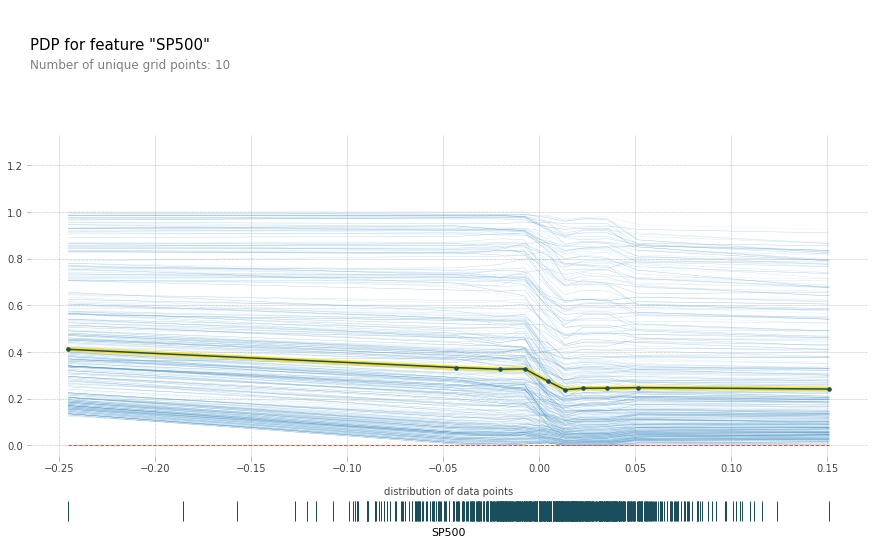

In [42]:
fig, axes = pdp.pdp_plot(pdp_sp500, 
                         'SP500', 
                         plot_lines=True, 
                         center=False, 
                         frac_to_plot=0.5,
                         plot_pts_dist=True, 
)

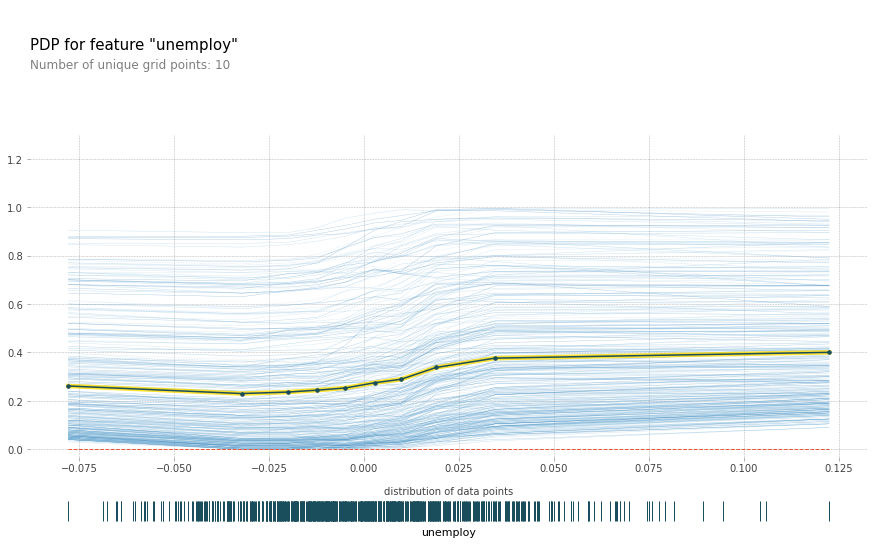

In [43]:
fig, axes = pdp.pdp_plot(pdp_unemploy, 
                         'unemploy', 
                         plot_lines=True, 
                         center=False, 
                         frac_to_plot=0.5,
                         plot_pts_dist=True, 
)

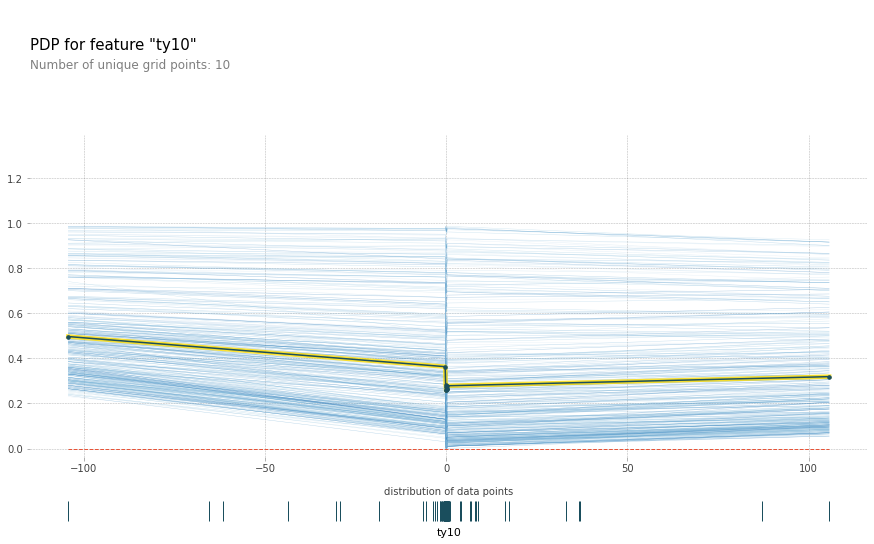

In [44]:
fig, axes = pdp.pdp_plot(pdp_ty10, 
                         'ty10', 
                         plot_lines=True, 
                         center=False, 
                         frac_to_plot=0.5,
                         plot_pts_dist=True, 
)

### SHAP

In [45]:
import shap

In [46]:
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X)

In [69]:
shap.summary_plot??

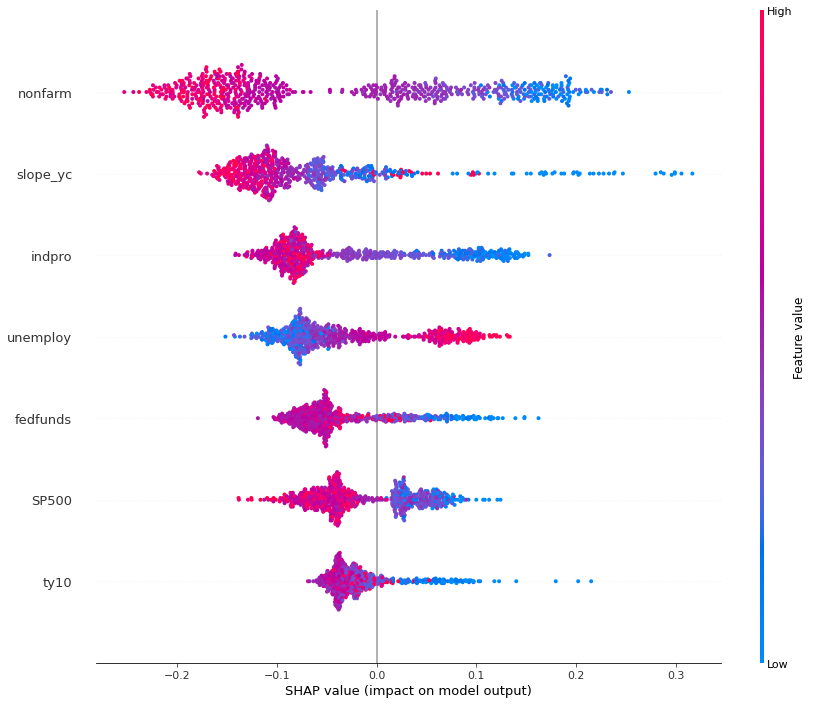

In [72]:
# summarize the effects of all the features
shap.summary_plot(shap_values[1], X, plot_type="dot",plot_size=(14,12))


In [48]:
shap_interaction_values = shap.TreeExplainer(clf).shap_interaction_values(X)

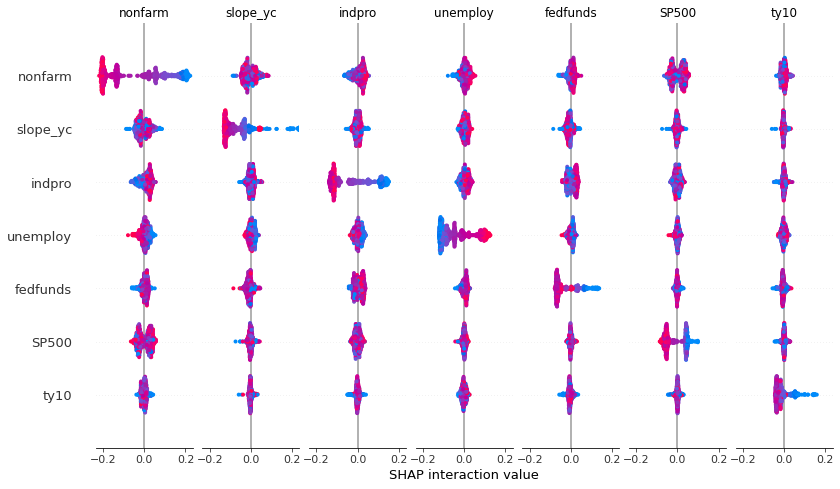

In [74]:
# summaries interaction effect
shap.summary_plot(shap_interaction_values[1], X, plot_size=(14,16))

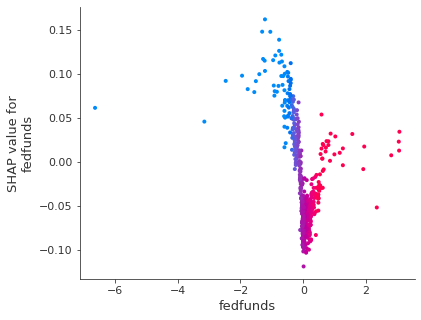

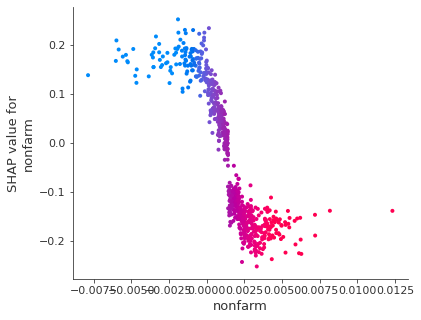

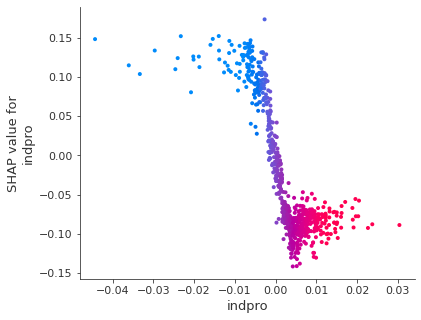

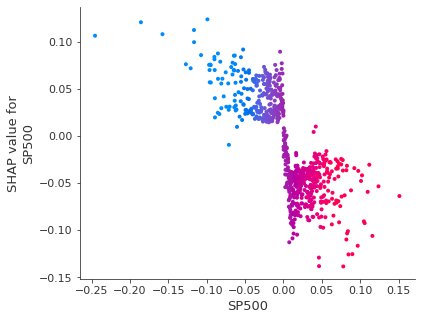

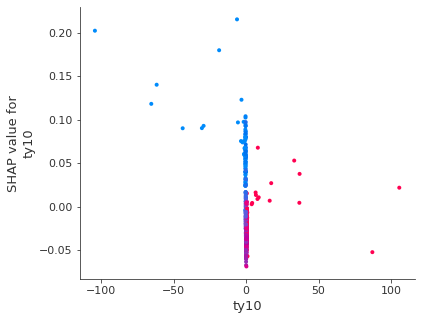

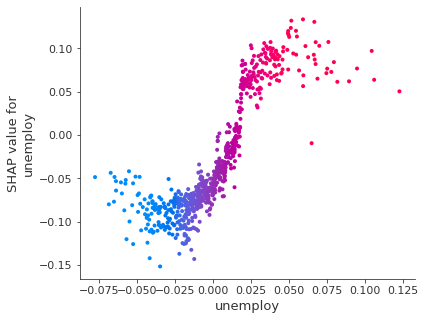

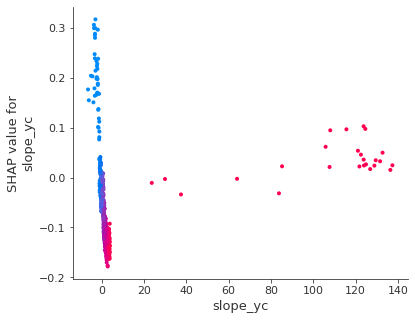

In [76]:
for feature in X.columns: 
    shap.dependence_plot(feature, shap_values[1], X, interaction_index=feature)

In [51]:
### Partial Dependence Plot 

In [52]:
interactions = [
    ['nonfarm', 'unemploy'],
    ['nonfarm', 'indpro'],
    ['fedfunds', 'unemploy'],
    ['fedfunds', 'SP500']
]

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


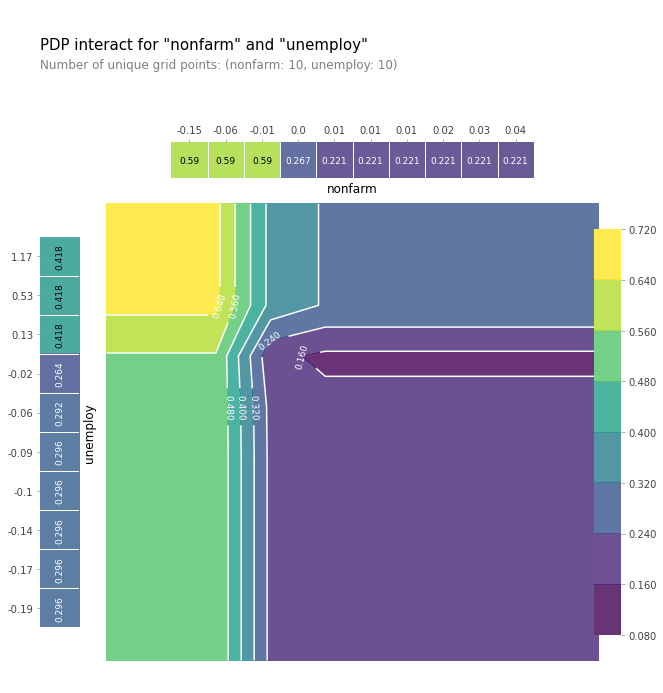

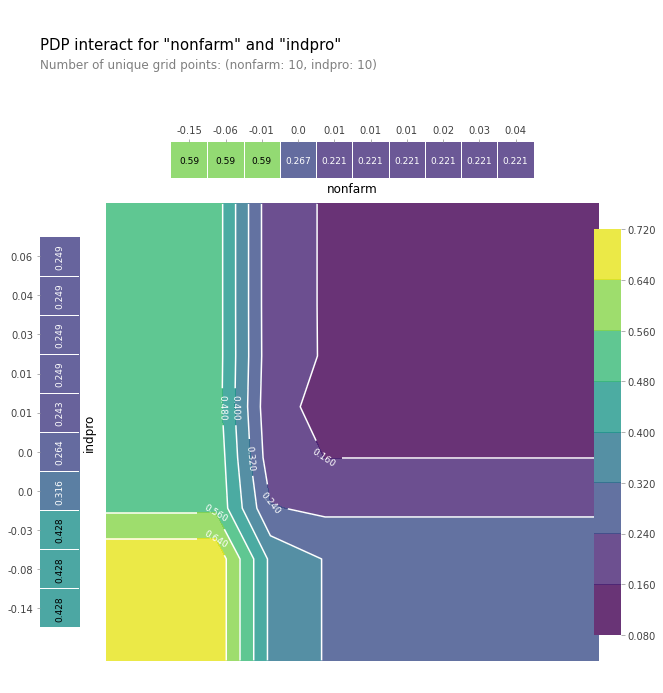

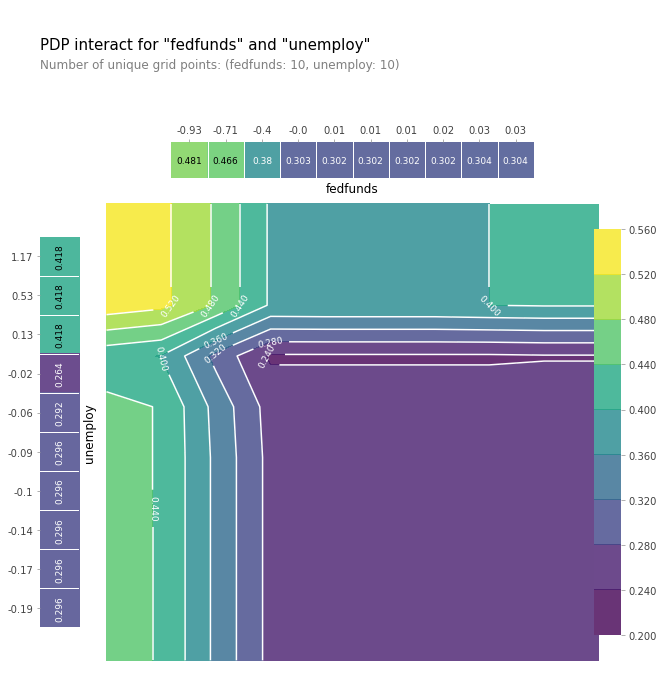

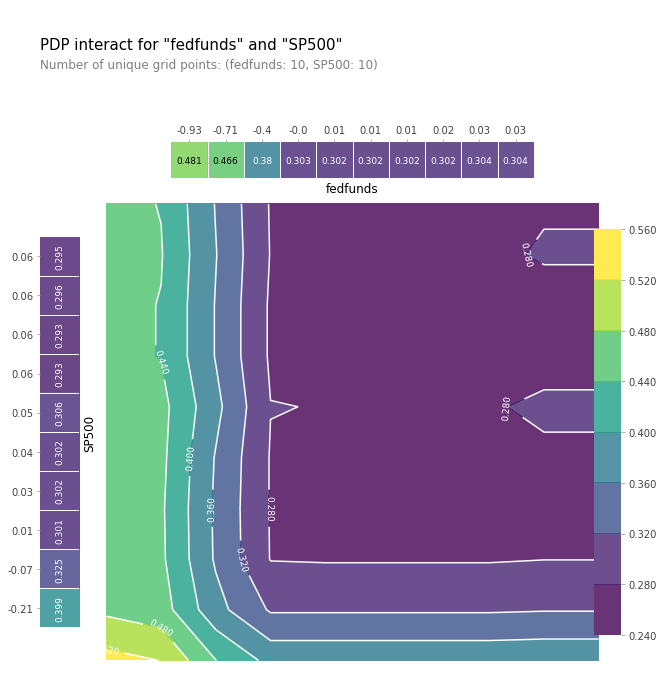

In [53]:
for i in interactions: 
    inter1 = pdp.pdp_interact(model=clf, dataset=data, model_features=X.columns, features=i)
    fig, axes = pdp.pdp_interact_plot(inter1, i, 
                                  plot_type='contour', 
                                  x_quantile=True, plot_pdp=True)

### Tree Interpreter

In [54]:
dtree = tree.DecisionTreeClassifier(max_depth=3)  
dtree.fit(X_train_rnd, y_train_rnd)
viz = dtreeviz(dtree, 
               X, 
               y,
               target_name='recession',
               feature_names=X.columns, 
               class_names=["no","yes"]
              )  
              
viz.view() 

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


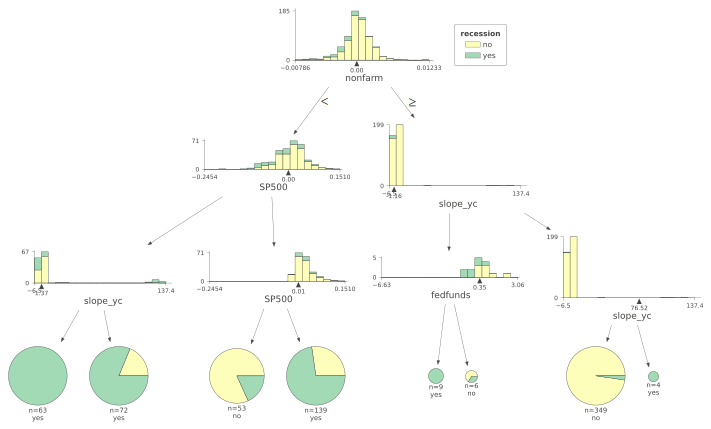

In [55]:
from IPython.display import display
display(viz)